## The Lorenz chaotic attractor

This example shows the construction of a classic chaotic dynamical system: the Lorenz "butterfly" attractor.  The equations are:
        
$$
\dot{x}_0 = \sigma(x_1 - x_0) \\\
\dot{x}_1 = x_0 (\rho - x_2) - x_1  \\\
\dot{x}_2 = x_0 x_1 - \beta x_2 
$$

Since $x_2$ is centered around approximately $\rho$, and since NEF ensembles are usually optimized to represent values within a certain radius of the origin, we substitute $x_2' = x_2 - \rho$, giving these equations:
$$
\dot{x}_0 = \sigma(x_1 - x_0) \\\
\dot{x}_1 = - x_0 x_2' - x_1\\\
\dot{x}_2' = x_0 x_1 - \beta (x_2' + \rho) - \rho
$$

For more information, see http://compneuro.uwaterloo.ca/publications/eliasmith2005b.html "Chris Eliasmith. A unified approach to building and controlling spiking attractor networks. Neural computation, 7(6):1276-1314, 2005."

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-colorblind')

from matplotlib import rc, rcParams
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':7})
rc('text', usetex=True)
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']

import nengo
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

In [35]:
model = nengo.Network()
with model:
#     num_intercepts = 3
#     num_max_rates = 4
#     num_encoders = 4
#     num_neurons = np.int_(1 + num_encoders * num_max_rates * num_intercepts)
#     encoders = np.concatenate(([[1,1,1]],
#                                np.tile([[1,1,1],
#                                        [1,1,-1],
#                                        [1,-1,1],
#                                        [1,-1,-1]], (np.int_(num_neurons/num_encoders),1))))
#     intercepts = np.concatenate(([0], np.tile(np.repeat([-0.5,0,0.5], num_encoders), 
#                                               np.int_(num_neurons/num_intercepts/num_encoders))))
#     max_rates = np.concatenate(([0], np.tile(np.repeat([0.5,1,1.5,2], 4),
#                                              np.int_(num_neurons/num_max_rates/num_encoders))))

# Alex's attempt
    s_pi = 0.1
    ints = [0,1/4]
    rats = s_pi * np.arange(1, 4)/2
    enst = [-1,1]
    
    num_intercepts = len(ints)
    num_max_rates = len(rats)
    num_encoders = len(enst) ** 2
#     if 0 in enst:
#         num_encoders -= 1
    num_neurons = np.int_(num_encoders * num_max_rates * num_intercepts)
    
    j = 0
    encoders = np.zeros(shape=(num_neurons, 3))
    intercepts = np.zeros(num_neurons)
    max_rates = np.zeros_like(intercepts)
    for ir in range(num_max_rates):
        for ii in range(num_intercepts):
            for ie0 in range(len(enst)):
                if ie0 is 0: 
                    continue
                for ie1 in range(len(enst)):
                    for ie2 in range(len(enst)):
                        vertex = np.array([enst[ie0], enst[ie1], enst[ie2]])
                        if not np.all(vertex == 0):
                            encoders[j,:] = vertex
                            intercepts[j] = ints[ii]
                            max_rates[j] = rats[ir]
                            j += 1
            
    # Constant neuron
#     encoders[j,:] = [1,1,1]
#     intercepts[j] = 0
#     max_rates[j] = 0
    
#     print(encoders)
#     print(intercepts)
#     print(max_rates)
    state = nengo.Ensemble(num_neurons, dimensions=3, intercepts=intercepts, neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=400,s_pi=s_pi),
                       max_rates=max_rates,
                       encoders=encoders, radius=60.)
# with nengo.Simulator(model) as sim:
#     eval_points, activities = tuning_curves(state, sim)
# plt.plot(eval_points, activities, lw=2)
# plt.xlabel("Input signal")
# plt.ylabel("Firing rate (Hz)")

tau = .1 # neuron synapse timeconstant
vtime = 1 # virtual time scale
dt = .001 / vtime # time step

sigma = 10
beta = 8.0/3
rho = 28

def feedback(x):
    dx0 = (-sigma * x[0] + sigma * x[1]) * vtime
    dx1 = (-x[0] * x[2] - x[1]) * vtime
    dx2 = (x[0] * x[1] - beta * (x[2] + rho) - rho) * vtime
    
    return [dx0 * tau + x[0], 
            dx1 * tau + x[1], 
            dx2 * tau + x[2]]

with model:
#     state = nengo.Ensemble(2000, 3, radius=60, neuron_type=nengo.neurons.LIF())
    #state = nengo.Ensemble(100, 3, radius=60, neuron_type=nengo.neurons.Sinusoid(max_overall_rate=400))
#     state = nengo.Ensemble(100, 3, radius=60, neuron_type=nengo.neurons.RectifiedLinear())
    conn = nengo.Connection(state, state, function=feedback, synapse=tau)
    variable_probe = nengo.Probe(state, synapse=dt)
    state_probe = nengo.Probe(state.neurons)
    weight_probe = nengo.Probe(conn, 'weights')

with nengo.Simulator(model, dt=dt) as sim:
    sim.run(8/vtime)

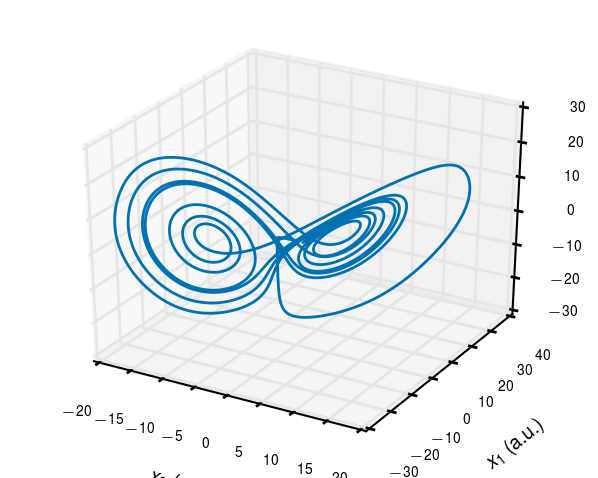

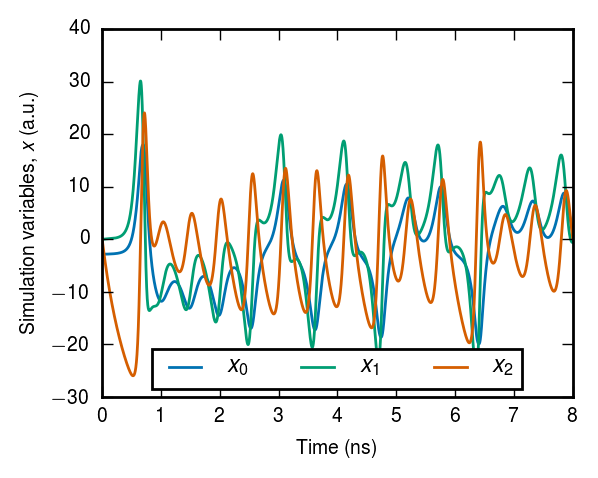

In [36]:
from mpl_toolkits.mplot3d import Axes3D
saving = False

if saving:
    pp = PdfPages('lorenz_system_3d.pdf')
fig = plt.figure(0, figsize=(3,2.4), dpi=72)
ax = fig.add_subplot(111, projection='3d')
dat3d = (sim.data[variable_probe][:, dim] for dim in range(3))
ax.plot(*dat3d)
ax.set_xlabel('$x_0$ (a.u.)')
ax.set_ylabel('$x_1$ (a.u.)')
ax.set_zlabel('$x_2$ (a.u.)')
for xlabel_i in ax.get_xticklabels():
    xlabel_i.set_fontsize(5.0)
for ylabel_i in ax.get_yticklabels():
    ylabel_i.set_fontsize(5.0)
for zlabel_i in ax.get_zticklabels():
    zlabel_i.set_fontsize(5.0)

plt.tight_layout()
if saving:
    pp.savefig()
    pp.close()
    pp = PdfPages('lorenz_time_traces.pdf')
fig = plt.figure(1, figsize=(3,2.4), dpi=72)
for variable, label in zip(sim.data[variable_probe].T, ['$x_0$', '$x_1$', '$x_2$']):
    plt.plot(sim.trange(), variable, label=label)
plt.legend(bbox_to_anchor=(0., .02, 1., .102), loc='lower center',
           ncol=3, borderaxespad=0.)
plt.xlabel('Time (ns)')
plt.ylabel('Simulation variables, $x$ (a.u.)')
plt.tight_layout()
if saving:
    pp.savefig()
    pp.close()


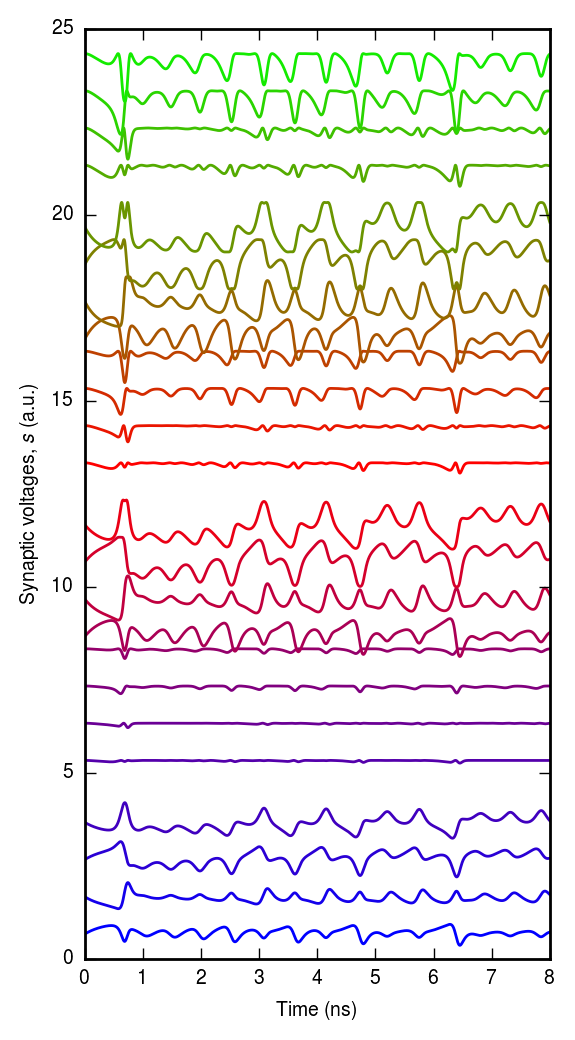

In [37]:
fig = plt.figure(2, figsize=(3,6), dpi=72)

cm = plt.get_cmap('brg') 
cNorm  = colors.Normalize(vmin=0, vmax=num_neurons)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(num_neurons):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(sim.trange(), sim.data[state_probe][:, i]/300 + i, color=colorVal)
plt.xlabel('Time (ns)')
plt.ylabel('Synaptic voltages, $s$ (a.u.)')

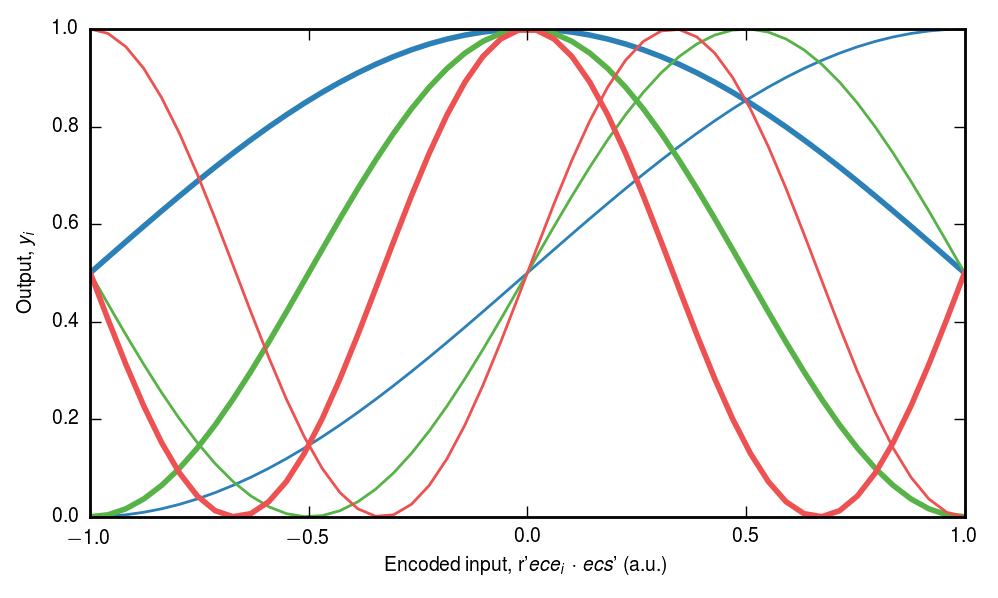

In [30]:
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ensemble import response_curves

saving = False

# Thomas version using tuning_curves

#1D encoders
# model = nengo.Network()
# with model:
#     num_neurons = np.int_(3*5)
#     encoders = np.tile([[1]], (np.int_(num_neurons),1))
#     intercepts = np.tile([-0.5,0,0.5], np.int_(num_neurons/3))
#     max_rates = np.tile([0,0.5,1,1.5,2], np.int_(num_neurons/5))
#     state = nengo.Ensemble(num_neurons, dimensions=1, intercepts=intercepts, neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=1),
#                        max_rates=max_rates,
#                        encoders=encoders, radius=60.)
#     state_probe = nengo.Probe(state)
    
# with nengo.Simulator(model) as sim:
#     eval_points, activities = tuning_curves(state, sim)

# Alex version
eval_points, responses = response_curves(state, sim)
if num_neurons != np.shape(responses)[1]:
    raise Exception('Number of neurons(' + str(num_neurons) + ') and response curves(' + str(np.shape(responses)[1]) + ') is inconsistent')

if saving:
    pp = PdfPages('tuning_curves.pdf')
fig = plt.figure(2, figsize=(5,3), dpi=72)
# jet = cm = plt.get_cmap('winter') 
# cNorm  = colors.Normalize(vmin=0, vmax=(num_neurons-1)/2)
cm = plt.get_cmap('Paired') 
cNorm  = colors.Normalize(vmin=0, vmax=12.01)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(0, int(num_neurons/num_encoders), 2):
    colorVal = scalarMap.to_rgba(i+1)
    plt.plot(eval_points, responses[:,i*(num_encoders)]/400, lw=1, hold=True, color=colorVal)
    colorVal = scalarMap.to_rgba(i+1)
    plt.plot(eval_points, responses[:,(i+1)*(num_encoders)]/400, lw=2, hold=True, color=colorVal)
plt.xlabel("Encoded input, r'$\vec{e}_i \cdot \vec{s}$' (a.u.)")
plt.ylabel("Output, $y_i$")
plt.tight_layout()
if saving:
    pp.savefig()
    pp.close()

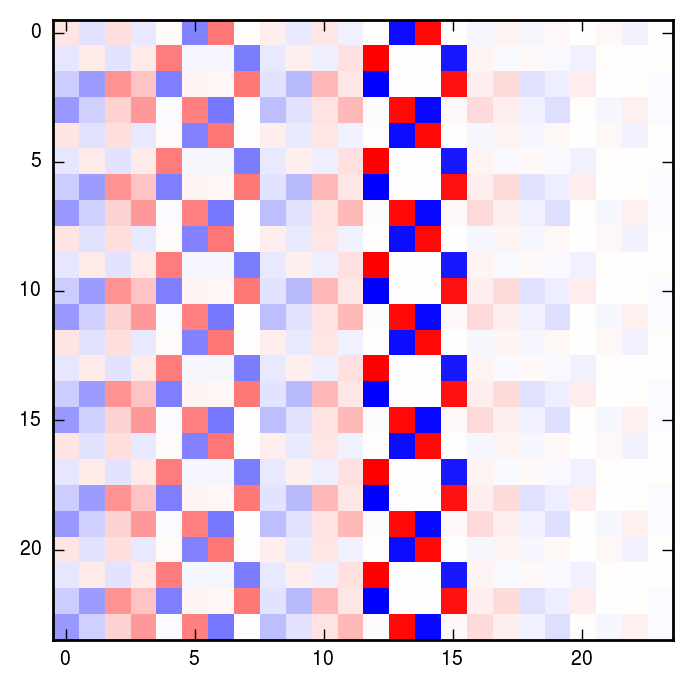

In [31]:
# the nengo's weight matrix is sim.data[weight_probe][0,:,:], but that gives the best approx to (x0, x1, x2)
# if you want the interconnection matrix you need to encode this vector using the encoders variable.
weight_matrix = np.dot(encoders, sim.data[weight_probe][0,:,:])

plt.imshow(weight_matrix, cmap='bwr', interpolation='nearest')

In [7]:
np.shape(weight_matrix)

(24, 24)

In [8]:
np.max(abs(weight_matrix))

0.37901969438523098